In [1]:
import pyaudio
import wave
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import IPython
import numpy as np
import sys
import os
from shutil import copyfile
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras.layers import Dropout
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  
import tensorflow as tf
tf.test.is_gpu_available()

Using TensorFlow backend.


True

In [2]:
dirname = 'Processed_Dataset'

In [3]:
folder = os.getcwd()
actors_folder_path = ['../RAVDESS/' + str(f) for f in os.listdir('../RAVDESS/') if os.path.isdir('../RAVDESS/' + str(f))]
print(actors_folder_path)
actors_folder = [str(f) for f in os.listdir('../RAVDESS/') if os.path.isdir('../RAVDESS/' + str(f))]
print(actors_folder)

['../RAVDESS/Actor_01', '../RAVDESS/Actor_02', '../RAVDESS/Actor_03', '../RAVDESS/Actor_04', '../RAVDESS/Actor_05', '../RAVDESS/Actor_06', '../RAVDESS/Actor_07', '../RAVDESS/Actor_08', '../RAVDESS/Actor_09', '../RAVDESS/Actor_10', '../RAVDESS/Actor_11', '../RAVDESS/Actor_12', '../RAVDESS/Actor_13', '../RAVDESS/Actor_14', '../RAVDESS/Actor_15', '../RAVDESS/Actor_16', '../RAVDESS/Actor_17', '../RAVDESS/Actor_18', '../RAVDESS/Actor_19', '../RAVDESS/Actor_20', '../RAVDESS/Actor_21', '../RAVDESS/Actor_22', '../RAVDESS/Actor_23', '../RAVDESS/Actor_24']
['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [4]:
directory = os.getcwd()
files = [f for f in os.listdir(dirname + '\\Actor_01') if f.endswith('.wav')]
print(files[0])
print(len(files))

Angry-Normal-01-01.wav
60


In [5]:
audio_path = dirname + '\\Actor_02\\' + str(files[6])
samplingFrequency, signalData = wavfile.read(audio_path)
print(type(signalData))
print(os.getcwd() + '\\' + audio_path)
## Play IPython audio
import IPython.display as ipd
ipd.Audio(audio_path) # load a local WAV file

<class 'numpy.ndarray'>
D:\PDF\7th_Sem\BTP\Model\Processed_Dataset\Actor_02\Angry-Strong-02-01.wav


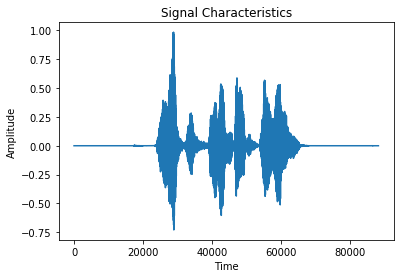

c:\python36\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


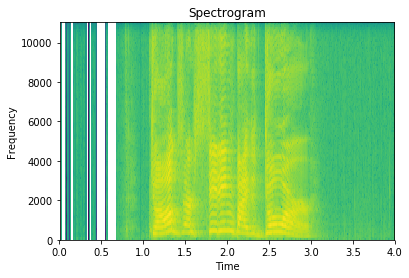

(1025, 173)


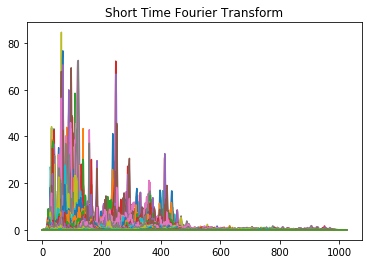

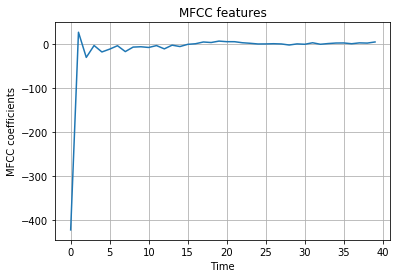

(128,)


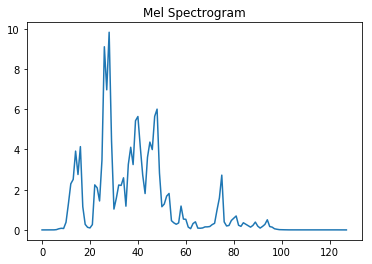

In [6]:
# Plot Signal
plt.plot(signalData)
plt.title('Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


## Plot Spectrogram
plt.specgram(signalData,Fs=samplingFrequency)
# plt.xlim(left = 0.7)
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

#STFT
stft = np.abs(librosa.stft(signalData))
print(stft.shape)
plt.plot(stft)
plt.title('Short Time Fourier Transform')
plt.show()

#MFCC
mfccs = np.mean(librosa.feature.mfcc(signalData, sr=samplingFrequency, n_mfcc = 40).T, axis = 0)
# print(mfccs.shape)
#Displaying  the MFCCs:
#librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.plot(mfccs)
plt.title('MFCC features')
plt.xlabel('Time')
plt.ylabel('MFCC coefficients')
plt.grid()
plt.show()

mel_spectrogram = np.mean(librosa.feature.melspectrogram(signalData, sr = samplingFrequency).T, axis = 0)
print(mel_spectrogram.shape)
plt.plot(mel_spectrogram)
plt.title('Mel Spectrogram')
plt.show()

In [31]:
def dyn_change(data, type = 'standard_normal'):
    """
    Random Value Change.
    """
    print(type)
    if type == 'uniform':
        dyn_change = np.random.uniform(low=3,high=3)
    elif type == 'standard_normal':
        dyn_change = np.random.standard_normal()
    elif type == 'Poisson':
        dyn_change = np.random.poisson(lam = 2.0)
    elif type == 'rayleigh':
        dyn_change = np.random.rayleigh()
    return data*dyn_change


## Pitch Tuning
# Shift the pitch of a waveform by n_steps semitones.
# Link: https://librosa.github.io/librosa/generated/librosa.effects.pitch_shift.html
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data1 = librosa.effects.pitch_shift(data, 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data1
    
## Random Shifting
def shift(data, type = 'left'):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-30, high = 50)*500)
    return np.roll(data, s_range)

## White Noise Adding
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data + noise_amp * np.random.normal(size = data.shape[0])
    return data

def AWGN(data):
    # Adding noise using target SNR

    # Set a target SNR
    target_snr_db = 30
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(data**2)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data**2))
    data = data + noise_volts
    
    return data

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.5116990e-05 1.3142598e-05
 0.0000000e+00]
[ 0.00136042 -0.00144881 -0.00160761 ...  0.00065912  0.00291221
  0.00355672]


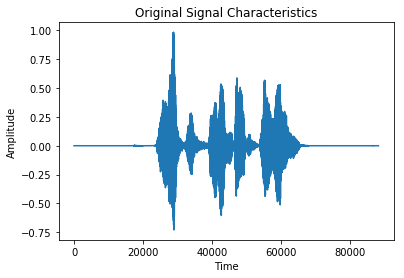

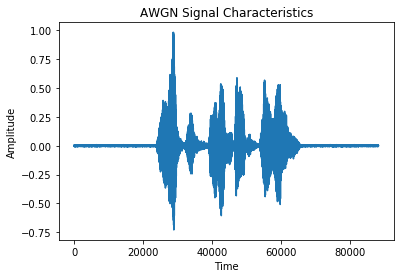

In [32]:
## White noise
AWGN_data = AWGN(signalData)
print(signalData)
print(AWGN_data)
CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
folder_loc = 'Test\\AWGN_30db_SNR.wav'

wavfile.write(folder_loc, samplingFrequency, AWGN_data)

import IPython.display as ipd
ipd.Audio(folder_loc) # load the recorded WAV file

# Plot Signal
plt.plot(signalData)
plt.title('Original Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot Signal
plt.plot(AWGN_data)
plt.title('AWGN Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(audio_path) # load the original WAV file

In [33]:
ipd.Audio(folder_loc)

[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.5116990e-05 1.3142598e-05
 0.0000000e+00]
[-0.00099152 -0.00056201  0.00024959 ...  0.00061067  0.00086055
 -0.00079126]


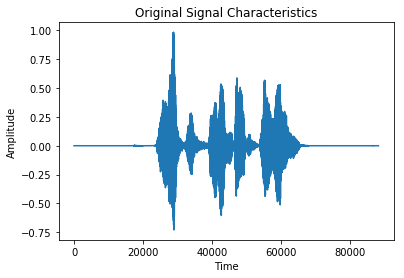

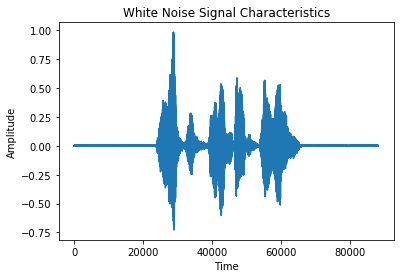

In [34]:
## White noise
white_noise_data = noise(signalData)
print(signalData)
print(white_noise_data)
CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
folder_loc = 'Test\\white_noise_data.wav'

wavfile.write(folder_loc, samplingFrequency, white_noise_data)

import IPython.display as ipd
ipd.Audio(folder_loc) # load the recorded WAV file

# Plot Signal
plt.plot(signalData)
plt.title('Original Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot Signal
plt.plot(white_noise_data)
plt.title('White Noise Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(audio_path) # load the original WAV file

In [35]:
ipd.Audio(folder_loc)

[ 1.31934414e-07 -1.46549354e-07  1.59879733e-07 ... -8.97144474e-08
  1.02774095e-07 -1.17054611e-07]


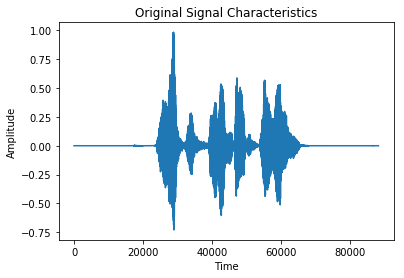

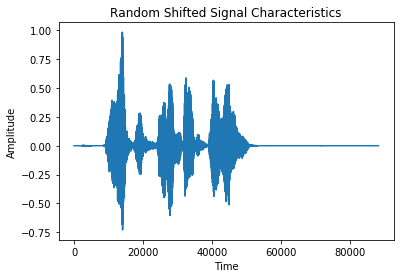

In [44]:
## Random Shifting
random_shift_data = shift(signalData)
print(random_shift_data)
CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
folder_loc = 'Test\\random_shift_data.wav'

wavfile.write(folder_loc, samplingFrequency, random_shift_data)

import IPython.display as ipd
ipd.Audio(folder_loc) # load the recorded WAV file

# Plot Signal
plt.plot(signalData)
plt.title('Original Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot Signal
plt.plot(random_shift_data)
plt.title('Random Shifted Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(audio_path) # load the original WAV file

In [41]:
ipd.Audio(folder_loc)

[ 8.5766267e-14  1.6850221e-12 -5.5039686e-13 ... -7.2500493e-06
  4.2700205e-07  1.5381778e-06]


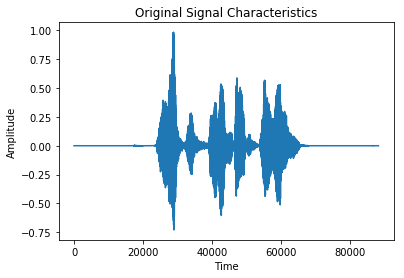

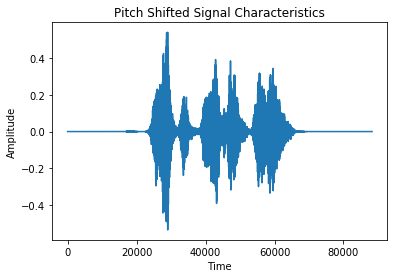

In [14]:
## Pitch Shift
pitch_shifted_data = pitch(signalData, samplingFrequency)
print(pitch_shifted_data)
CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
folder_loc = 'Test\\pitch_shifted_data.wav'

wavfile.write(folder_loc, samplingFrequency, pitch_shifted_data)

import IPython.display as ipd
ipd.Audio(folder_loc) # load the recorded WAV file

# Plot Signal
plt.plot(signalData)
plt.title('Original Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot Signal
plt.plot(pitch_shifted_data)
plt.title('Pitch Shifted Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(audio_path) # load the original WAV file

In [15]:
ipd.Audio(folder_loc)

rayleigh
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.44371425e-05
 1.25515435e-05 0.00000000e+00]


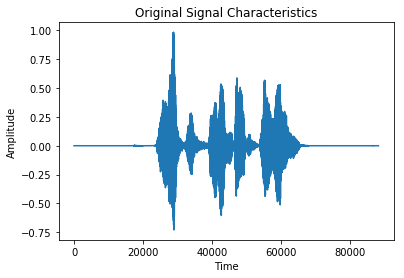

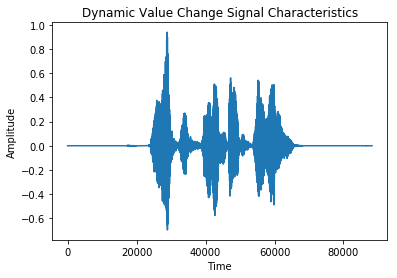

In [16]:
dyn_data = dyn_change(signalData, 'rayleigh')
print(dyn_data)
CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
folder_loc = 'Test\\Dyn_value_rayleigh.wav'

wavfile.write(folder_loc, samplingFrequency, dyn_data)

import IPython.display as ipd
ipd.Audio(folder_loc) # load the recorded WAV file

# Plot Signal
plt.plot(signalData)
plt.title('Original Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# Plot Signal
plt.plot(dyn_data)
plt.title('Dynamic Value Change Signal Characteristics')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

ipd.Audio(audio_path) # load the original WAV file

In [17]:
ipd.Audio(folder_loc)

In [18]:
signalData.shape
data= signalData
import pywt
train_data_cwt = np.ndarray(shape=(1, 127, 127))
scales = range(1,128)
waveletname = 'morl'
coeff, freq = pywt.cwt(signalData, scales, waveletname, 1)
coeff_ = coeff[:,:127]
train_data_cwt[0, :, :] = coeff_
# (coeffs, freq) = pywt.dwt(np.array(data), 'db38')

In [19]:
# print(pywt.wavelist(kind='discrete'))
train_data_cwt.shape

(1, 127, 127)

In [20]:
coeff.shape

(127, 88289)

In [21]:
freq.shape

(127,)

In [22]:
coeffs_ = coeffs[:127]

NameError: name 'coeffs' is not defined

In [ ]:
coeffs_.shape

In [66]:
np.mean(freq)

-1.4004759e-08

In [97]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(128, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(6, activation='softmax')(x)
# this is the model we will train
model_ = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
model_.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model_.fit()


model = VGG16(weights='imagenet', include_top=False)
x = train_data_cwt[0]
print(x.shape)
f = np.empty((127, 127, 3))
f[:, :, 0] = x
f[:, :, 1] = x
f[:, :, 2] = x
print(f.shape)
x = np.expand_dims(f, axis= 0)

print(x.shape)
x = preprocess_input(x)
features_ = model.predict(x)

(127, 127)
(127, 127, 3)
(1, 127, 127, 3)


In [98]:
features_.shape

(1, 3, 3, 512)